# QSAR - Random Forest Regression 

In [1]:
import numpy as np
import pandas as pd
import rdkit
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler

# Preprocessing data

In [3]:
PandasTools.RenderImagesInAllDataFrames(images=True)

In [4]:
dataframe = pd.read_csv('qsar_random_forests\datasets\dataset_1.csv', sep=';') # Caco2_MDCK_interactions
dataframe['SMILES'] = dataframe['SMILES'].astype('str') # convert object data type into explicit string

In [ ]:
# view dataset
dataframe

In [6]:
PandasTools.AddMoleculeColumnToFrame(frame=dataframe,smilesCol='SMILES',molCol='Molecule')


In [ ]:
dataframe.columns

## Computing fingerprints

In [9]:
def mol2fp(mol):
    """Compute fingerprint array from a SMILES molecule (mol). Returns array of sparse data."""
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=2048)
    array = np.zeros((0,), dtype=np.int32)
    DataStructs.ConvertToNumpyArray(fp, array)
    return array



In [217]:
# use this command to check fingerprints of the dataframe
# fp = mol2fp(Chem.MolFromSmiles(dataframe.loc[1,"SMILES"]))
# plt.matshow(fp.reshape(32,-1, order='C'), 0)

In [11]:
# Remove empty/damaged data based on empty Molecule frame
dataframe = dataframe[dataframe['Molecule'].notna()]
dataframe.Molecule.isna().sum() #checksum

0

In [12]:
# compute fingerprints 
dataframe["fpts"] = dataframe.Molecule.apply(mol2fp)

c:\Users\prage\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
from sklearn.model_selection import train_test_split
### TODO
extracted_nums = dataframe.copy()
extracted_nums.drop(columns = ['name', 'identifier', 'inchikey', 'pubchem',
       'drugbank', 'pdb', 'chEMBL', 'membrane', 'method','note','primary_reference','secondary_reference', 'Molecule','temperature','charge'], inplace=True)
extracted_nums.dropna(axis=1, how='any', inplace=True)


# Building the model

In [15]:
X = np.stack(dataframe.fpts.values)
y = extracted_nums.LogPerm.values.reshape((-1,1))

In [16]:
print("Dimensions of the dataframe:", X.shape)

Dimensions of the dataframe: (143, 2048)


In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.1, random_state=42)

In [194]:
# scaling into interval around 0
"""scaling = StandardScaler()
y_train = scaling.fit_transform(y_train)
y_test = scaling.transform(y_test)
y_validation = scaling.transform(y_validation)"""

'scaling = StandardScaler()\ny_train = scaling.fit_transform(y_train)\ny_test = scaling.transform(y_test)\ny_validation = scaling.transform(y_validation)'

In [31]:
# removing low-variance features
"""feature_select = VarianceThreshold(threshold=0.05)
X_train = feature_select.fit_transform(X_train)
X_validation = feature_select.transform(X_validation)
X_test = feature_select.transform(X_test)
X_train.shape"""

'feature_select = VarianceThreshold(threshold=0.05)\nX_train = feature_select.fit_transform(X_train)\nX_validation = feature_select.transform(X_validation)\nX_test = feature_select.transform(X_test)\nX_train.shape'

In [218]:
from sklearn.ensemble import RandomForestRegressor
X_train.shape

(102, 2048)

In [198]:
model = RandomForestRegressor(n_estimators=1024,n_jobs=-1, oob_score=True, random_state=42)
model.fit(X_train, y_train.ravel())

RandomForestRegressor(n_estimators=1024, n_jobs=-1, oob_score=True,
                      random_state=42)

In [199]:
model.score(X_validation, y_validation) # used to tune the hyperparameters

0.7357732824601946

In [200]:
y_predicted = model.predict(X_test)


In [221]:
# check shape of sets
print(X_test.shape)
print(y_predicted.shape)
print(y_test.ravel().shape)
print(y_validation.shape)

(29, 2048)
(29,)
(29,)
(12, 1)


# Comparing the data

In [208]:
# creating the frame with compared data
final_frame = pd.DataFrame({'LogPerm_predicted': y_predicted, 'LogPerm_actual':y_test.ravel()} )


In [209]:
import seaborn as sns

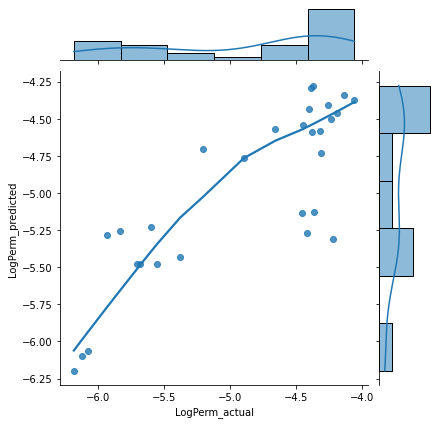

In [210]:
sns.jointplot(x="LogPerm_actual", y="LogPerm_predicted", data=final_frame, kind="reg", lowess=True)

<AxesSubplot:xlabel='LogPerm_predicted', ylabel='LogPerm_actual'>

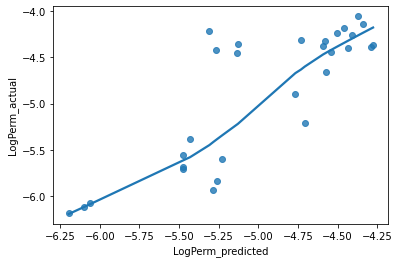

In [212]:
sns.regplot(data = final_frame, x = "LogPerm_predicted", y='LogPerm_actual',lowess=True)

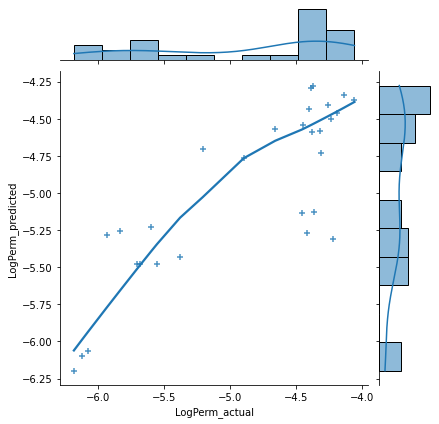

In [214]:
#sns.regplot(data = final_frame, x = "LogPerm_predicted", y="LogPerm_predicted" , lowess=True, hue="LogPerm_predicted")
#sns.set_palette("")
sns.jointplot(
    x="LogPerm_actual", y="LogPerm_predicted", data=final_frame,
    marker="+" , marginal_kws=dict(bins=10), kind="reg", lowess=True
)

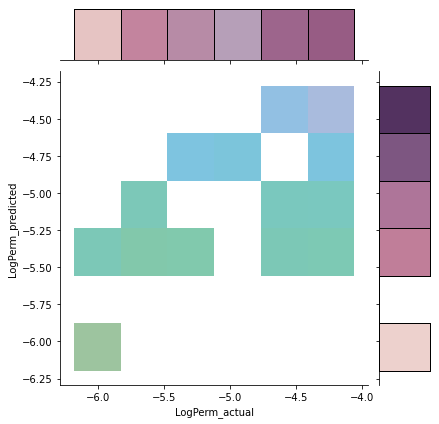

In [215]:
graph = sns.jointplot(
    x="LogPerm_actual", y="LogPerm_predicted", data=final_frame,
    kind="hist", hue="LogPerm_predicted",palette="ch:r=-.5,l=.75", legend=False)
